In [1]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import laspy as lp
import pdal
import pandas as pd
import open3d as o3d
from dbfread import DBF

import itertools

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors


# basedir = os.path.dirname(os.getcwd())
basedir = os.path.abspath(os.path.join(os.getcwd() ,"../"))
_py = os.path.join(basedir, 'py')
_data = os.path.join(basedir, 'data')

sys.path.insert(1, _py)
import loads
import lia
import ray as rayt
import lad
import figures

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

# %matplotlib qt
# %matplotlib inline

In [2]:
name = 'kiwifruit_interpine'
showpc = False

In [3]:
# load files
las = loads.loadlaz(name)

# See LAS columns names
point_format = las.point_format
if True:
    print(list(point_format.dimension_names))

['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'synthetic', 'key_point', 'withheld', 'overlap', 'scanner_channel', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'user_data', 'scan_angle', 'point_source_id', 'gps_time', 'red', 'green', 'blue']


In [4]:
# las to data frame
columns = ['x', 'y', 'z', 'intensity', 'return_number', 'number_of_returns', 'gps_time', 'red', 'green', 'blue']
las = pd.DataFrame(np.vstack((las.x, las.y, las.z, las.intensity, las.return_number, las.number_of_returns, las.gps_time, las.red, las.green, las.blue)).transpose(), columns=columns)

In [5]:
# shift x and y coordinates near zero
for i in ['x', 'y']:
    ismin = np.min(las[i])
    las[i] = las[i] - ismin

In [6]:
# Define point cloud with RGB colours
points = np.vstack((las.x, las.y, las.z)).transpose()
colors = np.vstack((las.red, las.green, las.blue)).transpose()

In [7]:
# trajectory file must be called `trajectory.dbf` anc must contain x, y, z and gpstime
# if trajectory not given, bellow we mock this following x, y and gps_time values from point cloud 
try:
    traj = loads.loaddbf(name)
    traj = pd.DataFrame(iter(traj)) # to pandas
except Exception as e:
    print('Error loading trayectory file:\n %s' %(e))
    print('A mock trajectory will be used.')

    xymin = np.amin(points[:,:2], axis=0)
    xymax = np.amax(points[:,:2], axis=0)
    xymock = np.linspace(xymin, xymax, 50)

    zmock = np.full((len(xymock), 1), 40, dtype=int)

    gpsmin = las.gps_time.min()
    gpsmax = las.gps_time.max()
    gpsmock = np.linspace(gpsmin, gpsmax, len(xymock)).reshape(len(xymock), 1)

    traj = np.append(xymock, zmock, axis=1)
    traj = np.append(traj, gpsmock, axis=1)

    traj = pd.DataFrame(traj, columns=['x', 'y', 'z', 'gpstime'])

points_t = np.vstack((traj.x, traj.y, traj.z)).transpose()

Error loading trayectory file:
 could not find file '/Users/omar/projects/planttech/data/kiwifruit_interpine/trajectory.dbf'
A mock trajectory will be used.


Next, we define a region to run our pipeline as we know much of the point cloud is not relevant for the posterior analysis

In [8]:
def get_PCsample(p):

    PCsample = (p[:,1] > 2.8*p[:,0] - 120) & (p[:,1] < 2.8*p[:,0] -80)
    PCsample &= (p[:,0] < -2.8*p[:,1] + 500) & (p[:,0] > -2.8*p[:,1] + 400)

    return PCsample

2003


Text(0, 0.5, '$y$')

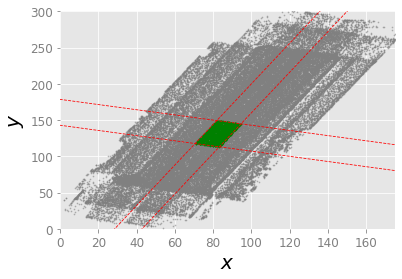

In [9]:
n = 1000
xymin = np.amin(points[:,:2][::n], axis=0)
xymax = np.amax(points[:,:2][::n], axis=0)

plt.scatter(points[:,0][::n], points[:,1][::n], s=0.5, c='gray', alpha=0.5)

x = np.linspace(xymin[0], xymax[0], 3)
y = np.linspace(xymin[1], xymax[1], 3)
plt.plot(x, 2.8*x - 80, ls='--', lw=0.8, c='r')
plt.plot(x, 2.8*x - 120, ls='--', lw=0.8, c='r')
plt.plot(-2.8*y + 400, y, ls='--', lw=0.8, c='r')
plt.plot(-2.8*y + 500, y, ls='--', lw=0.8, c='r')

PCsample = get_PCsample(points[::n])
print(PCsample.sum())
plt.scatter(points[:,0][::n][PCsample], points[:,1][::n][PCsample], c='g', s=0.5)

plt.xlim(0, 175)
plt.ylim(0, 300)

plt.xlabel(r'$x$', size=20)
plt.ylabel(r'$y$', size=20)


In [10]:
# plot the two point cloudsb
if showpc:
    pointslist = [points[::1000], points_t]
    colours = [colors[::1000]/2**16, [1, 0, 0]]
    loads.showPCDS(pointslist, colours)

In [11]:
# define and plot a sample of the point cloud
PCsample = get_PCsample(points)

pointslist = [points[PCsample], points_t]
colours = [colors[PCsample]/2**16, [1, 0, 0]]

In [12]:
if showpc:
    loads.showPCDS(pointslist, colours)

In [13]:
# interpolate trajectory with gps time
df = loads.coordsDF(las, traj)

In [14]:
df.head()

,x,y,z,xs,ys,zs
0,57.8851,52.6814,17.054934,0.000090,0.000153,40.0
1,58.1875,52.5695,17.030534,0.000099,0.000169,40.0
2,58.8075,52.3344,17.004434,0.000117,0.000200,40.0
3,59.1026,52.2180,16.970034,0.000126,0.000215,40.0
4,60.9687,51.4525,16.780334,0.000180,0.000307,40.0


In [15]:
# show sample of beams
if False:
    loads.showbeams(df[15000000:15000300])

## Tree and leaves segmentation

### DBSCAN mask

Text(0, 0.5, '$z$')

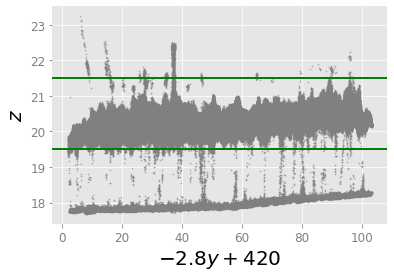

In [16]:
plt.scatter(-2.8*las['y'][PCsample] + 420, las['z'][PCsample], s=0.5, c='gray', alpha=0.5)
plt.axhline(19.5, c='g')
plt.axhline(21.5, c='g')

plt.xlabel(r'$-2.8y + 420$', size=20)
plt.ylabel(r'$z$', size=20)

Text(0, 0.5, '$z$')

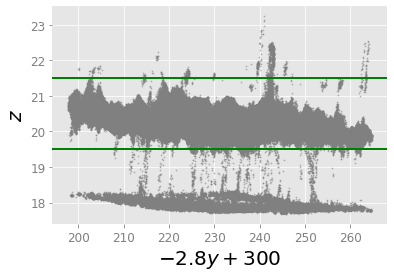

In [17]:
plt.scatter(2.8*las['x'][PCsample], las['z'][PCsample], s=0.5, c='gray', alpha=0.5)
plt.axhline(19.5, c='g')
plt.axhline(21.5, c='g')

plt.xlabel(r'$-2.8y + 300$', size=20)
plt.ylabel(r'$z$', size=20)

In [18]:

zmin, zmax, zfar = 19.5, 21.5, 23

keep = PCsample & (las.z > 20.8) & (las.z < zfar)
Ntot = keep.sum()

db = DBSCAN(eps=0.25).fit(points[keep])

labels = {}

for i in set(db.labels_):
    mask = db.labels_ == i
    perc = 100*mask.sum()/Ntot
    if perc > 1:
        # print(i, perc)
        labels[i] = mask

N = len(list(labels.keys()))

# plot the two point clouds
coltmp = plt.cm.jet(np.linspace(0,1,N))[:,0:3]

In [19]:
if showpc:
    pointslist = [points[keep][val] for val in labels.values()]
    colours = [list(i) for i in coltmp]
    loads.showPCDS(pointslist, colours)

In [20]:
above = np.zeros(len(points), dtype=bool)
keep = PCsample & (las.z > 20.8) & (las.z < zfar)

for val in labels.values():

    above[keep] |= val

keep = PCsample & ~above
rej = PCsample & above

In [21]:
if showpc:
    pointslist = [points[keep], points[rej]]
    colours = [colors[keep]/2**16, [1, 0, 0]]
    loads.showPCDS(pointslist, colours)

## Percentiles masking

In order to get rid of the stems of kiwifruit trees, first, we take a slide parallel to the stems arange. We have a total of two slides that folow equation:

$$y = 2.8x - 93 \\
y = 2.8x - 105, $$

each one with width of $2$.

Text(0, 0.5, '$y$')

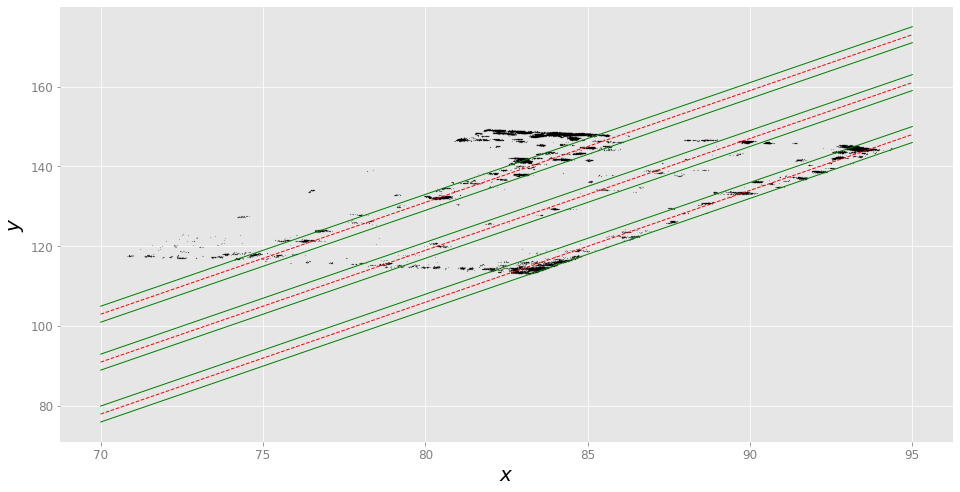

In [22]:
keep = PCsample & (las.z < 19.7) & (las.z > 18.2)

plt.figure(figsize=(16, 8))

plt.scatter(np.array(las.x)[keep], np.array(las.y)[keep], c='k', s=0.01)

x = np.linspace(70, 95, 20)

plt.plot(x, 2.8*x - 93, c='r', lw=1, ls='--')
plt.plot(x, 2.8*x - 105, c='r', lw=1, ls='--')
plt.plot(x, 2.8*x - 118, c='r', lw=1, ls='--')

for i in [2, -2]:

    plt.plot(x, 2.8*x - 93 + i, c='g', lw=1, ls='-')
    plt.plot(x, 2.8*x - 105 + i, c='g', lw=1, ls='-')
    plt.plot(x, 2.8*x - 118 + i, c='g', lw=1, ls='-')

plt.xlabel(r'$x$', size=20)
plt.ylabel(r'$y$', size=20)

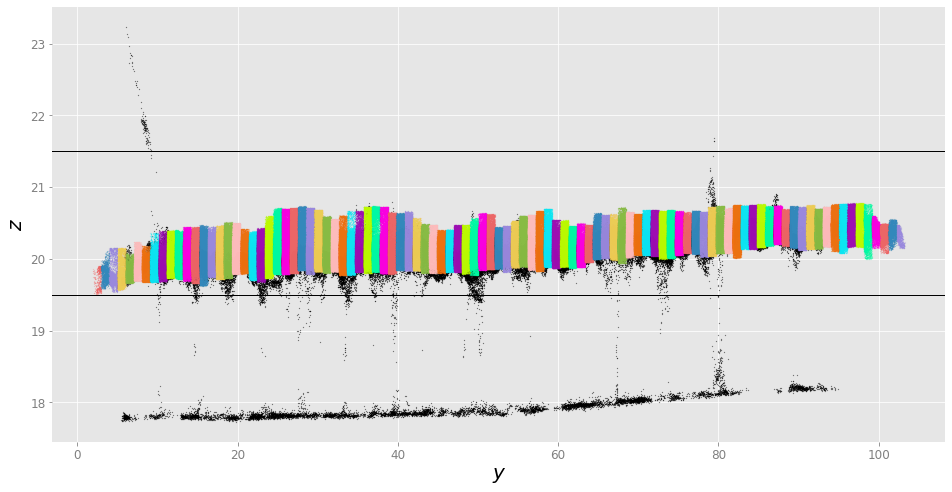

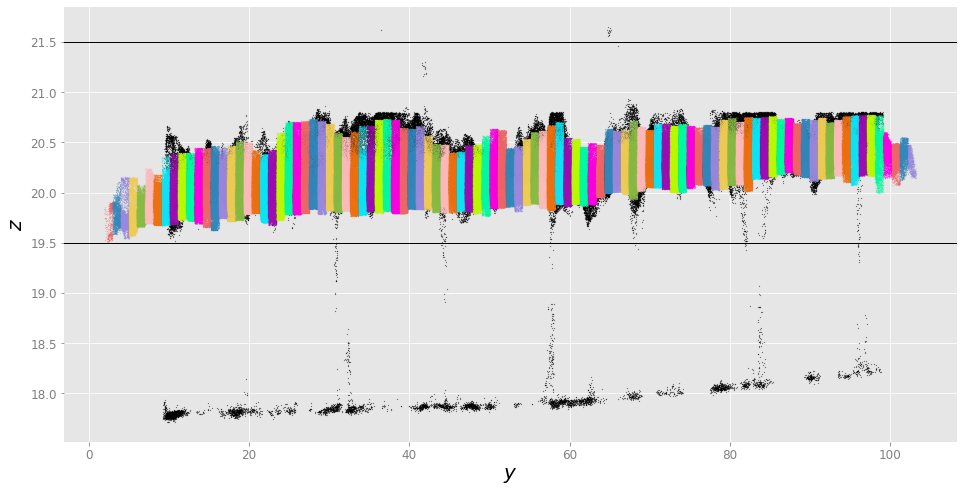

In [23]:
slides = {}

for num,i in enumerate([-93, -105]):
    slides['slide%s' %(str(num))] = (np.array(las.y) > 2.8*np.array(las.x) +i - 2) & (np.array(las.y) < 2.8*np.array(las.x) +i + 2)

below = np.zeros(len(points), dtype=bool)

for key, val in slides.items():

    keep = PCsample & i & (las.z > 19.5) & (las.z < 21.5) & ~above

    plt.figure(figsize=(16, 8))
    plt.scatter(-2.8*las['y'][PCsample & ~above & val][::1] + 420, las['z'][PCsample & ~above & val][::1], s=0.04, c='k')
    plt.axhline(19.5, lw=1, c='k')
    plt.axhline(21.5, lw=1, c='k')

    res, bcmask = loads.remove_outliers(-2.8*las['y'][keep] + 420, las['z'][keep], nbins=100, bounds=(2, 98.0))
    below[keep] |= ~bcmask

    plt.xlabel(r'$y$', size=20)
    plt.ylabel(r'$z$', size=20)



In [24]:
# sanity check: check that red dots corresponds to the regions we want to mask out
if showpc:
    keep = PCsample & ~above & ~below
    rej = PCsample & (above | below)
    pointslist = [points[keep], points[rej]]
    colours = [colors[keep]/2**16, [1, 0, 0]]
    loads.showPCDS(pointslist, colours)

In [25]:
# foliage
foliage = ~above & ~below & (las.z > 19.5) & (las.z < 21.5)
keep = PCsample & foliage
# rej = PCsample & ~foliage

In [26]:
if showpc:
    pointslist = [points[keep]]
    colours = [colors[keep]/2**16]
    loads.showPCDS(pointslist, colours)

In [27]:
N = PCsample.sum()
samp = PCsample & foliage

print('total # points in sample: %i' %(N))
print('total # points within foliage: %i, \t %.2f %%' %(samp.sum(), 100*samp.sum()/N))

total # points in sample: 2015758
total # points within foliage: 1857143, 	 92.13 %


In [28]:
def segtree(df, leaves, show=False):

    trees = {}
    centres = []
    # keepS = PCsample[::100]
    # PCsample = (points[:,1] > 0.34*points[:,0] - 3.0) & (points[:,1] < 0.34*points[:,0] + 5)
    # PCsample &= (points[:,0] < -0.35*points[:,1] - 10) & (points[:,0] > -0.35*points[:,1] - 20)
    # bins = np.arange(10, 20, 1)
    wi = 10
    wj = 10
    squares = list(itertools.product(np.arange(400, 500, wi), np.arange(-120, -80, wj)))

    if show:
        plt.figure(figsize=(20, 10))
        

    for num, (i,j) in enumerate(squares):

        keep = np.ones(len(df['x']), dtype=bool)
        keep &= (df['y'] > 2.8*df['x'] + j) & (df['y'] < 2.8*df['x'] + (j+wj))
        keep &= (df['x'] > -2.8*df['y'] + i) & (df['x'] < -2.8*df['y'] + (i+wi))

        # PCsample = (p[:,1] > 2.8*p[:,0] - 120) & (p[:,1] < 2.8*p[:,0] -80)
        # PCsample &= (p[:,0] < -2.8*p[:,1] + 500) & (p[:,0] > -2.8*p[:,1] + 400)
        # print(np.sum(keep))

        trees['tree_%s' %(str(num))] = keep
            
        if show:
            plt.scatter(df['x'][leaves & keep], df['y'][leaves & keep], s=0.5, label=i)
            p = ((i+0.5) - 0.35 * (j+0.5)) / (1 + (0.35 * 0.34))
            ya = 0.34*(p) + (j+0.5)
            centres.append([num, p, ya])
            # plt.scatter(p,ya, s=20, c='k')

            box = dict(facecolor='green', edgecolor='black', boxstyle='round,pad=0.5', alpha=0.8)
            text = 'tree_%s' %(str(num))

            # x = np.linspace(-18, -12, 5)
            # plt.plot(x, 0.34*x + j + 0.5, c='r', lw=1, ls='--')
            # plt.plot(x, (x - (i + 0.5))/(-0.35), c='r', lw=1, ls='--')

            plt.text(p, ya, text, size=10, bbox=box)

    if show:
        # plt.scatter(df['x'][leaves], df['y'][leaves], s=0.1, c='k')
        plt.xlabel(r'$x$', size=20)
        plt.ylabel(r'$y$', size=20)
        # plt.show()
        
    return trees, centres


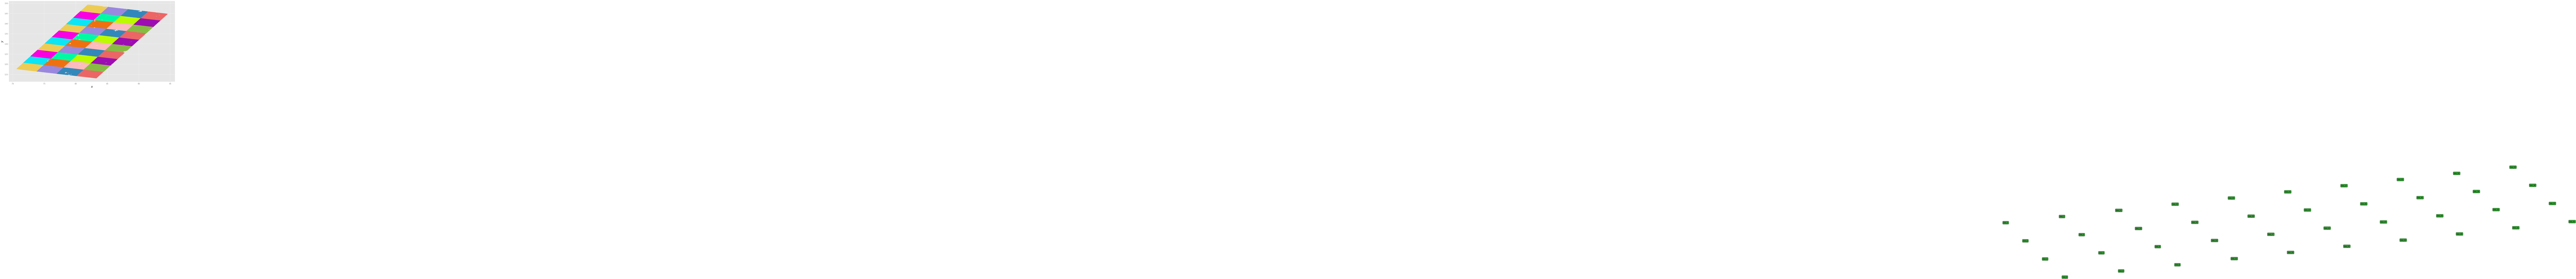

In [29]:
leaves = PCsample & foliage
trees, centres = segtree(df, leaves, show=True)

In [30]:
# save centre coordinates of patches
resdir = os.path.join(_data, name, 'lia')
if not os.path.exists(resdir):
    os.makedirs(resdir)
    
df_centres = pd.DataFrame(centres, columns=['tree_id', 'x', 'y'])
df_centres.to_csv(os.path.join(resdir, 'centres.csv'), index=False)

In [31]:
# show the point cloud from leaves of firs tree only
keep = (trees['tree_0']) & (leaves)
# loads.showPCfromDF(df[keep])

if showpc:
    pointslist = [points[keep]]
    colours = [colors[keep]/2**16]
    loads.showPCDS(pointslist, colours)

# `Leaf Inclination Angle` (LIA) estimation

On the contrary to the mock example, here we can not use function `lia.bestfit_pars_la` to get the best-fit parameters...

In [27]:

def run_lia(trees, name, voxel_size_w, kd3_sr, max_nn, voxel_size_h=0.1, savefig=True, savefig_extra=False):

    # load bestfit results      
    for num, (key, val) in enumerate(trees.items()):

        if num == 15: # for debug
        # if True:

            print('********* %s *********' %(key))

            keep = (val) & (leaves)
            points = df[['x', 'y', 'z']].to_numpy()[keep]

            text = '%s=%.4f \n %s=%.4f \n %s=%.4f ' %(
                                    'voxel_size_w', voxel_size_w,
                                    'kd3_sr', kd3_sr,
                                    'max_nn', max_nn)

            lia.leaf_angle(points, name, key, voxel_size_w, kd3_sr, max_nn, save=True,
                                        savefig=savefig, text=text, voxel_size_h=voxel_size_h, ismock=False,
                                        ylim=0.03, ylimh=0.45, savefig_extra=savefig_extra)

            # save indexes from main df
            # inds = np.where((val) & (leaves))
            np.save(os.path.join(_data, name, 'lia', 'inds_%s.npy' %(key)), keep)

In [99]:
run_lia(trees, name, voxel_size_w=0.01, kd3_sr=0.15, max_nn=300, 
voxel_size_h=0.05, savefig=True, savefig_extra=True)

********* tree_0 *********
********* tree_1 *********
********* tree_2 *********
********* tree_3 *********
********* tree_4 *********
********* tree_5 *********
********* tree_6 *********
********* tree_7 *********
********* tree_8 *********
********* tree_9 *********
********* tree_10 *********
********* tree_11 *********
********* tree_12 *********
********* tree_13 *********
********* tree_14 *********
********* tree_15 *********
********* tree_16 *********
********* tree_17 *********
********* tree_18 *********
********* tree_19 *********
********* tree_20 *********
********* tree_21 *********
********* tree_22 *********
********* tree_23 *********
********* tree_24 *********
********* tree_25 *********
********* tree_26 *********
********* tree_27 *********
********* tree_28 *********
********* tree_29 *********
********* tree_30 *********
********* tree_31 *********
********* tree_32 *********
********* tree_33 *********
********* tree_34 *********
********* tree_35 *********
**

## Files for Junqi

Following code takes `results_per_height_tree_<ID>.csv` file adds the `LAD` column and break the `values` array to asign a value to a column. Result is stored in Junqi directory with same name.

In [101]:
import glob

for file in glob.glob(os.path.join(_data, name, 'lia', 'results_per_*.csv')):
    # print(file)
    df_ = pd.read_csv(file)
    outfile = os.path.join(_data, name, 'lia', 'junqi', file.split('/')[-1])
    a = df_['values'].str[1:-1]
    keep = [len(i) > 0 for i in a]
    a = a.str.split(expand=True)
    df_['lad'] = np.arange(0, len(a))
    pd.concat([df_['zmin'][keep], df_['lad'][keep], a[keep]], axis=1).to_csv(outfile, index=False) 


# `Leaf Area Density` (LAD) estimation

In [102]:
for key, val in trees.items():

    keep = (val)
    print(key, np.sum(keep))

tree_0 54237
tree_1 58546
tree_2 35130
tree_3 55879
tree_4 52307
tree_5 57671
tree_6 35096
tree_7 56137
tree_8 51493
tree_9 57432
tree_10 35975
tree_11 56780
tree_12 51606
tree_13 57698
tree_14 35461
tree_15 56736
tree_16 50674
tree_17 58809
tree_18 36302
tree_19 56532
tree_20 49828
tree_21 57757
tree_22 35447
tree_23 57236
tree_24 51740
tree_25 58728
tree_26 35960
tree_27 56752
tree_28 49937
tree_29 57077
tree_30 37127
tree_31 56474
tree_32 49037
tree_33 56287
tree_34 37248
tree_35 56586
tree_36 48797
tree_37 57296
tree_38 36470
tree_39 59473


In [32]:
# downsampling is always implemented
voxel_size = 0.05

# set to a value to use Random-base downsampling instead of voxel-based downsampling
downsample = None
# to check everything looks fine
show = False
sample = None

### Implement and keep Downsampled points

Below code will implement a downsampling using either `random` or `voxel`. The donsampling is performed by saving the corresponding indexes list of the downsampled percentage from the original data size. If index list already exists we just take it to make the downsampling, if it does not exist yet, we created and save ir under its corresponding directory.

In [33]:

if downsample is not None:
    inds = lad.random_downsample(N, downsample, name)
    print('Random downsampling...')
else:
    inds = lad.voxel_subsampling(voxel_size, df[['x', 'y', 'z']].to_numpy())
    print('Voxel downsampling...')

print('Downsampling percentage: %.1f %%' %(100 *  len(inds) / len(df['x'])))

df = df.iloc[inds]
POINTS = df[['x', 'y', 'z']].to_numpy()
SENSORS = df[['xs', 'ys', 'zs']].to_numpy()
COLORS = colors[inds]

# Compute lower point
minpoint = np.min(POINTS, axis=0) # check this...
print('minpoint:', minpoint)

min point: [ 0.          0.         14.63463378]
max point: [176.168      300.5258      44.23783378]
Number of voxels: i:3524, j:6011, k:593 --> Total: 12561379052
Number of non-empty voxels: 24319865
Voxel downsampling...
Downsampling percentage: 39.4 %
minpoint: [ 0.          0.         14.63463378]


In [31]:
# save indexes of voxel-based downsample
if downsample is not None:
    dirname = 'random_%s' %(str(downsample))
    resdir = os.path.join(_data, name, dirname, 'lad_%s' %(str(voxel_size)))
else:
    dirname = 'voxel'
    resdir = os.path.join(_data, name, dirname, 'lad_%s' %(str(voxel_size)))

if not os.path.exists(resdir): os.makedirs(resdir)
outdir = os.path.join(resdir, 'inds.npy')
np.save(outdir, np.array(inds))

### leave and tree segmentation

In [33]:
leaves = leaves[inds]

for key, val in trees.items():
    trees[key] = val[inds]

In [34]:
if showpc:
    pointslist = [POINTS[leaves]]
    colours = [COLORS[leaves]/2**16]
    loads.showPCDS(pointslist, colours)

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


## Ray tracing

In [35]:

for key, val in trees.items():

    if key == 'tree_0': #for debug
    # if True:
        print('============== %s ==============' %(key))
        inPR = (leaves) & (val)
        minBB, maxBB = np.min(POINTS[inPR.values], axis=0), np.max(POINTS[inPR.values], axis=0)

        minpointPR = minpoint + np.floor(np.abs(minpoint - minBB)/voxel_size) * voxel_size
        maxpointPR = minpoint + np.ceil(np.abs(minpoint - maxBB)/voxel_size) * voxel_size

        if sample is not None:
            print('# iter...', len(POINTS[::sample]))
            m3s = rayt.main2(POINTS[::sample], SENSORS[::sample], POINTS[inPR], voxel_size, resdir, key, (minpointPR, maxpointPR), show=True)
        else:
            print('# iter...', len(POINTS))
            print('Results will be saved at %s' %(resdir))
            print('-------------')
            m3s = rayt.main2(POINTS, SENSORS, POINTS[inPR], voxel_size, resdir, key, (minpointPR, maxpointPR), show=False)

============== tree_0 ==============
# iter... 7466610
Results will be saved at /Users/omar/projects/planttech/data/kiwifruit_interpine/voxel/lad_0.1
-------------


7466610it [08:11, 15202.58it/s]

tot vox: 	 17028
voxels hitted: 	 11095
Percentage of voxels hitted by beam: 0.65
voxels hitted (OLD): 	 0
Percentage of voxels hitted by beam (OLD): 0.00


In [36]:
def runall(name, pointsPR, sensorsPR, inPR, voxel_size, tree, N, PRbounds, resdir, kbins=None, inverted=False):

    inds_file = os.path.join(resdir, 'inds.npy')
    inds0 = np.load(inds_file)
    inds_lia = np.load(os.path.join(_data, name, 'lia', 'inds_%s.npy' %(tree)))

    isfigures = os.path.join(resdir, 'figures')
    if not os.path.exists(isfigures):
        os.makedirs(isfigures)

    attributes2_file = os.path.join(resdir, 'm3s_%s_%s.npy' %(tree, str(voxel_size)))
    if os.path.isfile(attributes2_file):
        m3b = np.load(attributes2_file)

    print('voxel_size:', voxel_size)

    # Load LIAs and its weights saved at `get_lia()`.
    # Size of lias and ws arrays is the original size after leaf and tree extraction only.
    lias, ws = loads.load_lias_ws(name, tree)

    # Create  arrays of original size filled with -99
    lias0 = np.full(N, -99)
    ws0 = np.full(N, -99)

    # fill arrays with lias and ws values where it correspond to.
    lias0[np.where(inds_lia)[0]] = lias
    ws0[np.where(inds_lia)[0]] = ws

    # Finally, apply downsampling and second dowsampling to lias and ws.
    lias = lias0[inds0[inPR]]
    ws = ws0[inds0[inPR]]

    try:
        assert len(lias) == sum(inPR)
    except Exception as e:
        print('lias size does not match with Plant Region size.')
        print(e)

    try:
        assert len(ws) == sum(inPR)
    except Exception as e:
        print('ws size does not match with Plant Region size.')
        print(e)

    voxk = lad.get_voxk(pointsPR, PRbounds, voxel_size)
    bia = lad.get_bia(pointsPR, sensorsPR)
    meshfile = None

    figext = '%s_%s' %(tree, str(voxel_size))
    
    alphas_k = lad.alpha_k(bia, voxk, lias, ws, resdir, meshfile, figext=figext, 
                            klia=False, use_true_lia=False)

    kmax = m3b.shape[2]
    
    if kbins is None:
        kbins = int(kmax/15)
    print('kmax', kmax)
    print('kbins', kbins)

    oldlad = True
    
    lads_mid_1, clai_1 = lad.get_LADS2(pointsPR, kmax, voxel_size, kbins, alphas_k[:,6], PRbounds, tree, resdir, oldlad=oldlad, C=1)
    lads_0, clai_0 = lad.get_LADS2(pointsPR, kmax, voxel_size, kbins, alphas_k[:,6]*0+1, PRbounds, tree, resdir, oldlad=oldlad, C=1)

    lads = {'Correction Mean C=1':lads_mid_1, 'No Correction C=1':lads_0}
    attributes_file = os.path.join(resdir, 'm3s_%s_%s.npy' %(tree, str(voxel_size)))
    if os.path.isfile(attributes_file):
        RT = 'Y'
    else:
        RT = 'N'
        
    text = {'tree':tree, 'VS':voxel_size, 'Ray Tracing':RT, 'CLAI 1.0':np.round(clai_1, 3),  'CLAI 1.0 -- NC':np.round(clai_0, 3)}
    txt = []
    for key, val in text.items():
        txt.append('%s=%s \n' %(key, str(val)))
    text = (' ').join(txt)

    savefig = os.path.join(resdir, 'figures','LAD_%s.png' %(figext))
    figures.plot_lads(lads, text, savefig=savefig)


In [37]:
for key, val in trees.items():

    if key == 'tree_0': #for debug
    # if True:
        print('============== %s ==============' %(key))

        inPR = (leaves) & (val)
        runall(name, POINTS[inPR], SENSORS[inPR], inPR, voxel_size, key, len(points), (minpointPR, maxpointPR), resdir, kbins=1)

============== tree_0 ==============
voxel_size: 0.1
kmax 9
kbins 1


qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <_NSViewBackingLayer: 0x7fa51c513320> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <_NSViewBackingLayer: 0x7fa3136b0040> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <_NSViewBackingLayer: 0x7fa51c53fdf0> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <_NSViewBackingLayer: 0x7fa52c6b3020> contents scale of 2 - updating layer to match.


# DTM (not tested yet)

In [ ]:
POINTS = loads.DF2array(df[['x', 'y', 'z']])
# SENSORS = loads.DF2array(df[['xs', 'ys', 'zs']])

In [ ]:
keep = PCsample & (las.z < 0.8)
plt.figure(figsize=(16, 8))
plt.scatter(np.array(las.x)[keep][::1], np.array(las.z)[keep][::1], s=0.04, c='k')
plt.axhline(0.2, lw=1, c='k')

# res, bcmask = loads.remove_outliers(np.array(las.y)[keep], np.array(las.z)[keep], nbins=100, bounds=(0, 90))
# below[keep] |= ~bcmask

# plt.ylim(-1,4)

plt.xlabel(r'$x$', size=20)
plt.ylabel(r'$z$', size=20)

In [ ]:
keep = PCsample & (las.z < 0)
Ntot = keep.sum()

db = DBSCAN(eps=0.3).fit(points[keep])
# db = KMeans(n_clusters = 8, init='k-means++').fit(points[keep])

labels = {}

for i in set(db.labels_):
    mask = db.labels_ == i
    perc = 100*mask.sum()/Ntot
    if perc > 0:
        print(i, perc)
        labels[i] = mask

N = len(list(labels.keys()))

# plot the two point clouds
coltmp = plt.cm.jet(np.linspace(0,1,N))[:,0:3]

pointslist = [points[keep][val] for val in labels.values()]
colours = [list(i) for i in coltmp]
loads.showPCDS(pointslist, colours)

In [ ]:
alpha = 0.8
keep = PCsample & (las.z < 0)
pcd = loads.points2pcd(POINTS[keep], colors=[1,0,0])
downpcd = pcd.voxel_down_sample(voxel_size=0.05)
print(f"alpha={alpha:.3f}")
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(downpcd, alpha)
mesh.compute_vertex_normals()
# pcd = loads.points2pcd(POINTS[keep], colors=[1,0,0])
# downpcd = pcd.voxel_down_sample(voxel_size=0.05)
o3d.visualization.draw_geometries([downpcd, mesh.paint_uniform_color([0.5, 0.3, 0.1])], mesh_show_back_face=True)

In [ ]:
print('filter with average with 1 iteration')
mesh_out = mesh.filter_smooth_simple(number_of_iterations=2)
mesh_out.compute_vertex_normals()
print(mesh)
vertices = np.asarray(mesh_out.vertices)
pcd = loads.points2pcd(vertices, colors=[1,0,0])
mesh_name = os.path.join(_data, name, 'dtm_mesh.obj')
o3d.io.write_triangle_mesh(mesh_name, mesh_out)
o3d.visualization.draw_geometries([pcd, mesh_out], mesh_show_back_face=True)

In [ ]:
np.savetxt(os.path.join(_data,'DTM_vertices.csv'), vertices, fmt="%.8f", delimiter=",")